# Bezier curves

In [1]:
import torch 
import numpy as np 

In [2]:
np.random.random(5)

array([0.43074865, 0.03009089, 0.79450187, 0.61231875, 0.46227514])

In [3]:
#The coefficient matrix for cubic Bezier curves
M3 = torch.Tensor(
    [[-1, +3, -3, +1],
     [+3, -6, +3,  0],
     [-3, +3,  0,  0],
     [+1,  0,  0,  0]]
)

M2 = torch.Tensor(
    [[ 1, -2, 1],
     [-2,  2, 0],
     [ 1,  0, 0]]
)

In [4]:
#Setting the t resolution of the curves to 1000 points 
n=1000
t = torch.Tensor(np.linspace(0.0, 1.0, n))
print(t.size())
T2 = torch.stack([t**2,t**1,t**0]).transpose(0,1)
T3 = torch.stack([t**3,t**2,t**1,t**0]).transpose(0,1)
print(T3.size())
print(T3)

torch.Size([1000])
torch.Size([1000, 4])
tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00],
        [1.0030e-09, 1.0020e-06, 1.0010e-03, 1.0000e+00],
        [8.0240e-09, 4.0080e-06, 2.0020e-03, 1.0000e+00],
        ...,
        [9.9401e-01, 9.9600e-01, 9.9800e-01, 1.0000e+00],
        [9.9700e-01, 9.9800e-01, 9.9900e-01, 1.0000e+00],
        [1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00]])


## Drawing some cubic curves

torch.Size([2, 1000])
torch.Size([2, 1000])
torch.Size([2, 1000])
torch.Size([2, 1000])
torch.Size([2, 1000])


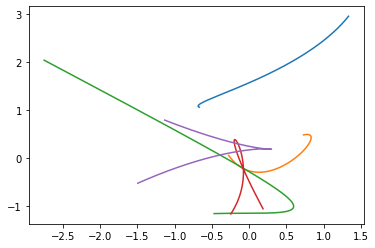

In [5]:
import matplotlib.pyplot as plt

#lets draw some random cubic curves
for i in range(5): 
    #4 random control points. Note the order of dimensions. This is to match the matrix multiplication
    C = torch.randn(size=(4,2))  
    pts = T3.mm(M3).mm(C).transpose(0,1)
    print(pts.size())
    plt.plot(pts[0].numpy() ,pts[1].numpy())
plt.show()

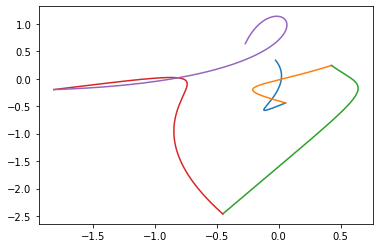

In [6]:
#Now lets make sure that the curves form a continuouse line. 
#This means that the first point of the next curve is the last point of the previous. 
#In total we have 3 points for each of the 5 splines plus the first point  
nsplines = 5
C = torch.randn(size=(5*3+1,2))  
for i in range(nsplines): 
    Ci = C[i*3:i*3+4]  
    pts = T3.mm(M3).mm(Ci).transpose(0,1)
    plt.plot(pts[0].numpy(),pts[1].numpy())
plt.show()

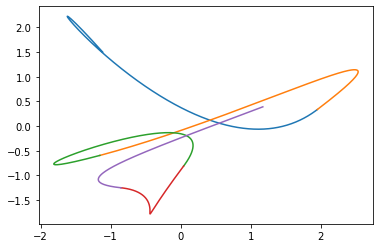

In [12]:
#Now lets ensure smooth connections between the lines. 
#Recall that the second and the third control points control the tangent the beninning and the end of the curve.
#So we have even less randomness here. 
nsplines = 5
C = torch.randn(size=(nsplines*2+2,2)) #[C#3,C01,C03,C04=C11,C13,C14=C21,C23,C24=C31,...]  
for i in range(0,nsplines): 
    Ci = torch.stack([
        C[i*2+1],
        2*C[i*2+1] - C[i*2],
        C[i*2+2],
        C[i*2+3],
    ])
    pts = T3.mm(M3).mm(Ci).transpose(0,1)
    plt.plot(pts[0].numpy(),pts[1].numpy())
    #plt.scatter(Ci.T[0],Ci.T[1])
plt.show()

## Interpolation using quadratic curves 

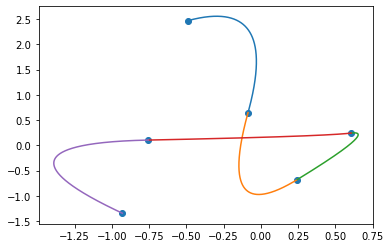

In [15]:
#Lets do the same for quadratic curves. Now it is one control point less!
nsplines = 5
C = torch.randn(size=(nsplines+1,2)) #[C01,C03=C11,C13=C21,...]  

#plot the dots. Why T? Because we want to select each axis separately 
plt.scatter(C.transpose(0,1)[0],C.transpose(0,1)[1])

CC = torch.randn(size=(2,))
for i in range(0,nsplines): 
    CC = 2*C[i] - CC
    Ci = torch.stack([
        C[i],
        CC,
        C[i+1],
    ])
    pts = T2.mm(M2).mm(Ci).transpose(0,1)
    plt.plot(pts[0].numpy(),pts[1].numpy())
plt.show()

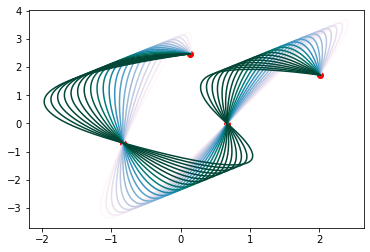

In [11]:
#And now lets keep the data points the same but play with the control point CC

cmap = plt.get_cmap("PuBuGn")

nsplines = 3
for j in range(20):
    CC = torch.Tensor([j*0.2,j*0.2])
    for i in range(0,nsplines): 
        CC = 2*C[i] - CC
        Ci = torch.stack([
            C[i],
            CC,
            C[i+1],
        ])
        pts = T2.mm(M2).mm(Ci).transpose(0,1)
        plt.plot(pts[0].numpy(),pts[1].numpy(), color=cmap(j*20))
plt.scatter(C.transpose(0,1)[0][:nsplines+1],C.transpose(0,1)[1][:nsplines+1], color="red")
plt.show()

## Interpolation using cubic curves

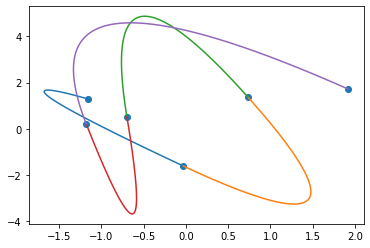

In [17]:
#Lets do the same for quadratic curves. Now it is one control point less!
nsplines = 5
C = torch.randn(size=(nsplines+1,2)) #[C01,C03=C11,C13=C21,...]  


#plot the dots. Why T? Because we want to select each axis separately 
plt.scatter(C.transpose(0,1)[0],C.transpose(0,1)[1])

CC = torch.randn(size=(2,))
for i in range(0,nsplines): 
    CC = 2*C[i] - CC
    Ci = torch.stack([
        C[i],
        CC,
        C[i+1],
    ])
    pts = T2.mm(M2).mm(Ci).transpose(0,1)
    plt.plot(pts[0].numpy(),pts[1].numpy())
plt.show()

## Least sqares fitting of a cubic curve

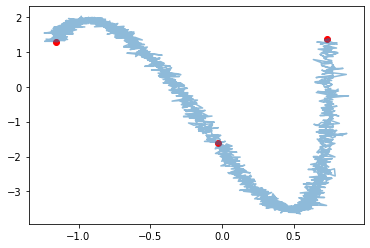

In [18]:
#Lets take two quadratic Bezier splines, store their concatenation in P, and add some noise
P=[]
CC = torch.randn(size=(2,))
nsplines = 2
for i in range(0,nsplines): 
    CC = 2*C[i] - CC
    Ci = torch.stack([
        C[i],
        CC,
        C[i+1],
    ])
    pts = T2.mm(M2).mm(Ci).transpose(0,1)
    P.append(pts)

#concatenate the splines
P = torch.cat(P,dim=1)

#add noise
P += torch.randn_like(P)*0.04

plt.plot(P[0].numpy(),P[1].numpy(), alpha=0.5) #alpha makes the lines transparent
plt.scatter(C.transpose(0,1)[0][:nsplines+1],C.transpose(0,1)[1][:nsplines+1],color="red")
plt.show()

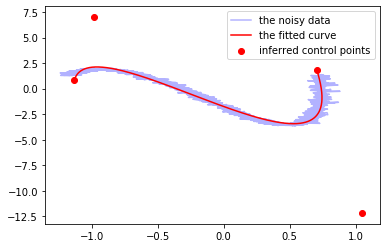

In [19]:
#Now we will reconstruct the curve using cubic Bezier
n=P.size()[1]
t = torch.Tensor(np.linspace(0.0, 1.0, n))
T = torch.stack([t**3,t**2,t**1,t**0]).transpose(0,1)

#see equation on slide 42 - Least squares Bezier fit
Cfit = M3.inverse().mm((T.transpose(0,1).mm(T)).inverse()).mm(T.transpose(0,1)).mm(P.transpose(0,1))

#get the new curve
pts = T.mm(M3).mm(Cfit).transpose(0,1)


plt.plot(P[0].numpy(),P[1].numpy(),alpha=0.3, color="blue", label="the noisy data")
plt.scatter(Cfit.transpose(0,1)[0],Cfit.transpose(0,1)[1], color="red", label="inferred control points")
plt.plot(pts[0].numpy(), pts[1].numpy(), color="red", label="the fitted curve")
plt.legend()
plt.show()


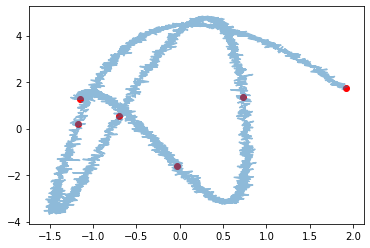

In [20]:
#How about fitting something more complex, like 5 quadratic splines? 
P=[]
CC = torch.randn(size=(2,))
nsplines = 5
for i in range(0,nsplines): 
    CC = 2*C[i] - CC
    Ci = torch.stack([
        C[i],
        CC,
        C[i+1],
    ])
    pts = T2.mm(M2).mm(Ci).transpose(0,1)
    P.append(pts)

#concatenate the splines
P = torch.cat(P,dim=1)

#add noise
P += torch.randn_like(P)*0.04

plt.plot(P[0].numpy(),P[1].numpy(), alpha=0.5) #alpha makes the lines transparent
plt.scatter(C.transpose(0,1)[0][:nsplines+1],C.transpose(0,1)[1][:nsplines+1],color="red")
plt.show()

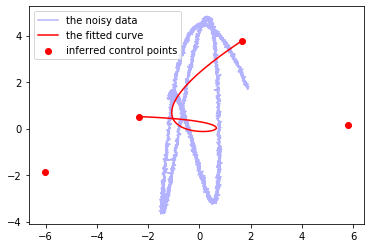

In [21]:
#Same code - copy paste - 
# ;-) you may write your Jupiter notebooks this way but NOT your python modules!!

n=P.size()[1]
t = torch.Tensor(np.linspace(0.0, 1.0, n))
T = torch.stack([t**3,t**2,t**1,t**0]).transpose(0,1)

#see equation on slide 42 - Least squares Bezier fit
Cfit = M3.inverse().mm((T.transpose(0,1).mm(T)).inverse()).mm(T.transpose(0,1)).mm(P.transpose(0,1))

#get the new curve
pts = T.mm(M3).mm(Cfit).transpose(0,1)


plt.plot(P[0].numpy(),P[1].numpy(),alpha=0.3, color="blue", label="the noisy data")
plt.scatter(Cfit.transpose(0,1)[0],Cfit.transpose(0,1)[1], color="red", label="inferred control points")
plt.plot(pts[0].numpy(), pts[1].numpy(), color="red", label="the fitted curve")
plt.legend()
plt.show()


That's the best we can do for a Bezier curve of the 3'd degree.

### An open question

What about fitting an arbitrary **unordered** set of points?  

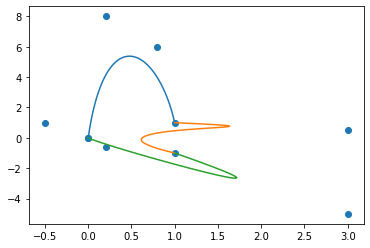

In [29]:
nsplines = 3
knots=[(0,0),(1,1),(1,-1)]
control=[(0.2,8),(0.8,6),(3,0.5),(-1,0.5),(3,-5),(0.2,-0.6)]
C = torch.Tensor([(0,0),(0.2,8),(0.8,6),(1,1),(3,0.5),(-0.5,1),(1,-1),(3,-5),(0.2,-0.6),(0,0)])

plt.scatter(C.transpose(0,1)[0],C.transpose(0,1)[1])

for i in range(0,nsplines): 
    Ci = torch.stack([
        C[i*3],
        C[i*3+1],
        C[i*3+2],
        C[i*3+3],
    ])
    pts = T3.mm(M3).mm(Ci).transpose(0,1)
    plt.plot(pts[0].numpy(),pts[1].numpy())
plt.show()